In [0]:
import tensorflow as tf
import numpy as np
np.random.seed(123)
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imread
from tensorflow.python.framework import ops
import math

import pandas as pd
import keras.backend as K

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, \
                         Flatten, Convolution2D, MaxPooling2D, \
                         BatchNormalization, UpSampling2D
from keras.utils import np_utils
from scipy import ndimage
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border

Using TensorFlow backend.


In [0]:
K.set_image_dim_ordering('th')
# helper function to load the image and downsample it by 4
jimread = lambda x: np.expand_dims(imread(x)[::4, ::4],0)
#load images and masks
#data_path = os.path.join('..', 'input')

all_images = glob(os.path.join('2d_images', '*.tif'))
all_masks = ['_masks'.join(c_file.split('_images')) for c_file in all_images]
print(len(all_masks), 'matching files found')


267 matching files found


In [0]:
images = np.stack([jimread(i) for i in all_images], 0)
masks = np.stack([jimread(i) for i in all_masks], 0) / 255.0

#Preprocess
preImages = np.stack([imread(i)[::4, ::4] for i in all_images], 0)
for idx,image in enumerate(preImages):
    binary = image < -400
    cleared = clear_border(binary)
    preImages[idx] = preImages[idx] * cleared

#plt.imshow(preImages[0])
images = np.expand_dims(preImages, 1)
print(images.shape)

(267, 1, 128, 128)


In [1]:
X_train, X_test, y_train,  y_test = train_test_split(images, masks, test_size=0.1)
print('Training input is', X_train.shape)
print('Training output is {}, min is {}, max is {}'.format(y_train.shape, y_train.min(), y_train.max()))
print('Testing set is', X_test.shape)

NameError: ignored

In [0]:
SEED=42
#Data augmentation
def image_augmentation_generator(xtrain, ytrain, batch_size):
    data_generator = ImageDataGenerator(
            rotation_range=90).flow(xtrain, xtrain, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(
           rotation_range=90).flow(ytrain, ytrain, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

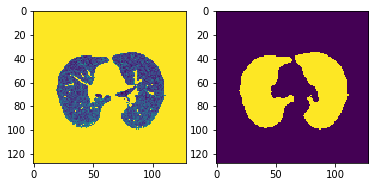

In [0]:
first_image = images[0]
first_mask = masks[0]
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(first_image[0])
ax2.imshow(first_mask[0])

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [0]:
# Create a deep nn
model = Sequential()
model.add(Convolution2D(filters=32, 
                        kernel_size=(3, 3), 
                        activation='sigmoid', 
                        input_shape=images.shape[1:],
                        padding='same'
                        ))
model.add(Convolution2D(filters=64, 
                        kernel_size=(3, 3), 
                        activation='sigmoid', 
                        input_shape=images.shape[1:],
                        padding='same'
                        ))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dense(64, activation='sigmoid'))
model.add(Convolution2D(filters=1, 
                        kernel_size=(3, 3), 
                        activation='sigmoid', 
                        input_shape=images.shape[1:],
                        padding='same'
                        ))
model.add(UpSampling2D(size=(2,2)))

model.compile(loss='binary_crossentropy',
             optimizer='rmsprop',
             metrics=[dice_coef])
#print(model.summary())

In [0]:
history = model.fit_generator(image_augmentation_generator(X_train, y_train,8),
                           steps_per_epoch = 10,
                           validation_data = (X_test, y_test),
                           epochs=10, verbose=1)

Epoch 1/10


In [0]:
#fig,ax=plt.subplots(1,2)
plt.plot(history.history['loss'], color='b',label='Loss')
plt.plot(history.history['val_loss'], color='r',label='Validation Loss')
plt.title("Loss")
plt.xlabel('Epoch#')
plt.ylabel('Loss')
plt.legend()
plt.savefig('lo.png')
plt.show()
plt.plot(history.history['dice_coef'], color='b',label='Dice Coefficient')
plt.plot(history.history['val_dice_coef'], color='r',label='Validation Dice Coefficient')
plt.title("Dice Coefficient")
plt.xlabel('Epoch#')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('dc.png')
plt.show()

In [0]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize = (20, 8))
ax1.imshow(X_test[0,0])
ax2.imshow(y_test[0,0])
ax3.imshow(model.predict(X_test)[0,0])#, cmap="Greys")
ax4.imshow(X_test[2,0])
ax5.imshow(y_test[2,0])
ax6.imshow(model.predict(X_test)[2,0])#, cmap="Greys")

In [0]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [0]:
# serialize model to JSON
model_json = model.to_json()
modelFileName = "kaggle_model_"
with open(modelFileName + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(modelFileName + ".h5")
print("Saved model to disk")